# Objective: Perform an Exploratory Data Analysis(EDA) on Bike Sharing in San Jose

# Note
- When running the colab, please make sure to respond to Google drive mount pop up window. It will ask you whether Colab can accesss your Google drive.

# EDA summary 
- Load libraries 
- Import bike data from URL 
  - Glimpse of the variavbles and data statistics
    - Most popular stations in each area
  - Investigate NaN or Null in the dataset
  - Fill NaN with proper value by utilizing other data
- Main EDA section
  - Add new feature : Bike travel distance(dist_km) and time duration(time_delta) 
  - User group analysis : Registered vs Unregistered user ratio
  - Bike ride count per bike and member type
  - Bike user's geographical analysis with map
    - Start station 
    - End station
    - Most popular station in San Francisco, San Jose ,and Oakland
  - Number of bike rides on weekdays/weekends for Member(registered) vs. Casual(unregistered)
  - Create new Metric: Daily Bike Occupancy Index
  - Bike usage trend for 1 month
  - Dailye bike ride demand trend per bike type
    - Second order regression of bike ride data for future demand prediction
  - Hourly trip data for each user type
  - Ride time duration related data analysis
    - Violin plot : Ride time duration per member type
    - Violin plot : Ride time duration on weekends and weekdays per member
  - Ride distance related data analysis
    - Violin plot : Ride distance per member type
    - Violin plot : Ride distance on weekends and weekdays per member
     






# Import Libraries

We import necessary libraries such as sklearn, scipy, pandas, numpy, and seaborn.

In [ ]:
# Each plot will not open a new window
%matplotlib inline

# Python fundamental libraries
import os
import time
from collections import defaultdict
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as mpatches
import seaborn as sns

# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 
# Install Folium for Geographic data visualization
!pip install folium
# Install plotlyExpress
!pip install plotly_express
!pip install contextily
# Disable warnings for more clear output
import warnings 
warnings.filterwarnings('ignore')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsig

## Import Data from URL
- Data is directly copied from bike data URL
- Saved file will be unziled and saved in '/content/202108-baywheels-tripdata.csv'

In [ ]:
# Load data
## Mount google drive 
from google.colab import drive
import os.path 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## When downloading starts, the following question can show up. Then just type yes
- replace __MACOSX/._202108-baywheels-tripdata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: --> type yes

In [ ]:
!wget https://s3.amazonaws.com/baywheels-data/202108-baywheels-tripdata.csv.zip
!unzip -o '202108-baywheels-tripdata.csv.zip'
!ls
df1 = pd.read_csv('202108-baywheels-tripdata.csv') ## This is for testing


--2022-02-21 06:15:57--  https://s3.amazonaws.com/baywheels-data/202108-baywheels-tripdata.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.195.88
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.195.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8345625 (8.0M) [application/zip]
Saving to: ‘202108-baywheels-tripdata.csv.zip’

202108-baywheels-tr 100%[===================>]   7.96M  14.2MB/s    in 0.6s    

2022-02-21 06:15:58 (14.2 MB/s) - ‘202108-baywheels-tripdata.csv.zip’ saved [8345625/8345625]

Archive:  202108-baywheels-tripdata.csv.zip
  inflating: 202108-baywheels-tripdata.csv  
  inflating: __MACOSX/._202108-baywheels-tripdata.csv  
202108-baywheels-tripdata.csv	   gdrive    sample_data
202108-baywheels-tripdata.csv.zip  __MACOSX


In [ ]:
# Load data into pandas DataFrames
# file_path_org : original source data file path after downloading from the URL
# file_path_nan_processing : nan-processed data file path
#     - Nan processing takes around 10 min. To aovid long wait, nan-processed dataframe will be saved to Google Drive for future use 

file_path_org = '/content/202108-baywheels-tripdata.csv'
file_path_nan_processed = '/content/nan_fill_trip_data.csv'

# If nan-processed csv file already exists, load nan-processed file. Otherwise, load original csv file from file_path_org
if os.path.exists(file_path_nan_processed):
    df_trip_data = pd.read_csv(file_path_nan_processed)     
else:
    df_trip_data = pd.read_csv(file_path_org)

df_trip = df_trip_data.copy(deep = True)
# A glimpse of the data set
df_trip.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,A67CB6CC130B48AB,electric_bike,2021-08-07 13:30:11,2021-08-07 14:08:57,S Van Ness Ave at Market St,SF-J23-2,The Embarcadero at Bryant St,SF-G30-2,37.774554,-122.419896,37.787410,-122.388207,member
1,EA6D1C08FB8D1751,classic_bike,2021-08-16 18:34:12,2021-08-16 18:34:14,7th Ave at Cabrillo St,SF-J12,7th Ave at Cabrillo St,SF-J12,37.775120,-122.464998,37.775120,-122.464998,member
2,91E70C07BFA0BAED,electric_bike,2021-08-31 18:28:04,2021-08-31 19:12:40,7th Ave at Cabrillo St,SF-J12,7th Ave at Cabrillo St,SF-J12,37.775129,-122.464995,37.775115,-122.465001,member
3,1A5E792757C33356,electric_bike,2021-08-10 17:52:44,2021-08-10 18:02:46,23rd St at Tennessee St,SF-Q30,McKinnon Ave at 3rd St,SF-W29,37.755349,-122.388703,37.736519,-122.389884,member
4,B2EA7B7711640610,electric_bike,2021-08-11 18:01:21,2021-08-11 18:09:37,23rd St at Tennessee St,SF-Q30,McKinnon Ave at 3rd St,SF-W29,37.755397,-122.388636,37.736311,-122.389896,member


## A glimpse of the variables and data statistics
- There are 13 features in the dataset 
  - ride_id : Unique ride event id
  -	rideable_type : types of bikes which will be identified later as eletric, classic ,and docked bike
  -	started_at : bike ride start time in YYYY-MM-DD HH:MM:SS format 
  -	ended_at : bike ride end time in YYYY-MM-DD HH:MM:SS format 
  - start_station_name : name of station where bike ride starts
  -	start_station_id : start station identification code
  -	end_station_name : name of station where bike ride ends
  -	end_station_id: start station identification code
  - start_lat	: latitude of start station 
  - start_lng	: longitude of start station 
  - end_lat	: latitude of end station 
  - end_lng	: lngitude of end station 
  - member_casual : type of bike user , member(registered) vs casual(unregistered)

In [ ]:
# A glimpse of the data statistics
df_trip.describe(include = 'object').transpose()

,count,unique,top,freq
ride_id,207023,207023,A67CB6CC130B48AB,1
rideable_type,207023,3,electric_bike,138598
started_at,207023,194952,2021-08-25 17:58:08,4
ended_at,207023,194495,2021-08-22 15:01:47,5
start_station_name,166811,465,Market St at 10th St,2423
start_station_id,166811,465,SF-J23-1,2423
end_station_name,162712,466,Market St at 10th St,2391
end_station_id,162712,466,SF-J23-1,2391
member_casual,207023,2,casual,121661


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Check nan in the original dataset
df_trip_org = pd.read_csv(file_path_org)
check_for_nan = df_trip_org.isnull().sum()
print(check_for_nan)    
  

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    40212
start_station_id      40212
end_station_name      44311
end_station_id        44311
start_lat                 0
start_lng                 0
end_lat                 276
end_lng                 276
member_casual             0
dtype: int64


### Quick look at the most popular station in each location 
- San Francisco : Market St at 10th st
- San Jose : Alameda at Bush St
- Oakland : MacArcher Bart station

In [ ]:
df_trip['start_station_id'] = df_trip['start_station_id'].astype(str)
df_sf = df_trip[df_trip['start_station_id'].str.contains("SF-")].describe(include = 'object')
df_sj = df_trip[df_trip['start_station_id'].str.contains("SJ-")].describe(include = 'object')
df_ok = df_trip[df_trip['start_station_id'].str.contains("OK-")].describe(include = 'object')


In [ ]:
## San Francisco
print("\n Most popular start station in SF area")
print(df_sf.transpose()['top'].loc['start_station_name'] )
## San Jose
print("\n Most popular start station in San Jose area")
print(df_sj.transpose()['top'].loc['start_station_name'])
## Oakland
print("\n Most popular start station in Oakland area")
print(df_ok.transpose()['top'].loc['start_station_name'])


 Most popular start station in SF area
Market St at 10th St

 Most popular start station in San Jose area
The Alameda at Bush St

 Most popular start station in Oakland area
MacArthur BART Station


## Fill NaN data 

1. "start/end station name" and "start/end station id" have non-negligible amount of NaN. They need to be properly handled. 
- nan in start_station_name:    40212
- nan in start_station_id:      40212
- nan in end_station_name:      44311
- nan in end_station_id:        44311

2. end_lat/lng columns have only 276 NaN out of 207023 elements, which is just 0.133%. Also if "end_lat" and "end_lng" are NaN, station name and id are also NaN. That makes these NaN datasets are not useful for data analysis. These NaN  can be simply removed. 



### 1. Fill nan in start/end station name and id.
- After carefully reviewing data, it is found out that all the rows that contains NaN in the start/end station name/id have longitude(lng) and latitidue(lat). So we can estimate the missing station name and id by comparing the lat and lng with other lat and lng. The station name and id from the other rows with closest lat and lng can be used to fill missing NaN. 
- Code explanation
  - Step1: Create unique station name and id table "uniq_start_station_table" by dropping duplicates

  - Step2: Define NaN row list 
  - Step3: Find the row with closest lat and lng vlaue to the NaN row

In [ ]:
### Fill nan in "Start station" column (only if nan has not been processed previously)
## nan processing takes long time so it will be processed only if nan-processed file doesn't exist
if os.path.exists(file_path_nan_processed) == False:
    uniq_start_station_table = df_trip[['start_station_name', 'start_station_id', 'start_lat', 'start_lng']].dropna().drop_duplicates(subset=['start_station_name'])
    check_for_nan = df_trip['start_station_name'].isnull().tolist()
    nan_list = [i for i, x in enumerate(check_for_nan) if x]
    lat = df_trip['start_lat'].iloc[nan_list]
    lng = df_trip['start_lng'].iloc[nan_list]
    cnt=0
    for i in nan_list:
        cnt+=1
        if cnt%2000 == 1:
          print("Start station NA fill progress: ", cnt/len(nan_list))
        temp_df = (uniq_start_station_table['start_lat'] - lat.loc[i])**2 + (uniq_start_station_table['start_lng'] - lng.loc[i])**2
        est_index = temp_df - temp_df.min() ==0
        station_name_est = uniq_start_station_table['start_station_name'][est_index]
        station_id_est = uniq_start_station_table['start_station_id'][est_index]
        df_trip['start_station_name'].iloc[i] = station_name_est
        df_trip['start_station_id'].iloc[i] = station_id_est  


Start station NA fill progress:  2.4868198547697204e-05
Start station NA fill progress:  0.049761265293942106
Start station NA fill progress:  0.09949766238933652
Start station NA fill progress:  0.14923405948473092
Start station NA fill progress:  0.19897045658012533
Start station NA fill progress:  0.24870685367551976
Start station NA fill progress:  0.29844325077091416
Start station NA fill progress:  0.34817964786630856
Start station NA fill progress:  0.39791604496170296
Start station NA fill progress:  0.44765244205709737
Start station NA fill progress:  0.49738883915249177
Start station NA fill progress:  0.5471252362478862
Start station NA fill progress:  0.5968616333432806
Start station NA fill progress:  0.646598030438675
Start station NA fill progress:  0.6963344275340694
Start station NA fill progress:  0.7460708246294638
Start station NA fill progress:  0.7958072217248583
Start station NA fill progress:  0.8455436188202526
Start station NA fill progress:  0.895280015915647

In [ ]:
if os.path.exists(file_path_nan_processed) == False:
    uniq_end_station_table = df_trip[['end_station_name', 'end_station_id', 'end_lat', 'end_lng']].dropna().drop_duplicates(subset=['end_station_name'])
    ### Fill nan in "End station" column
    check_for_nan = df_trip['end_station_name'].isnull().tolist()
    nan_list = [i for i, x in enumerate(check_for_nan) if x]
    lat = df_trip['end_lat'].iloc[nan_list]
    lng = df_trip['end_lng'].iloc[nan_list]
    cnt=0
    for i in nan_list:
        cnt+=1
        if cnt%2000 == 1:
          print("End station NA fill progress: ", cnt/len(nan_list))
        temp_df = (uniq_end_station_table['end_lat'] - lat.loc[i])**2 + (uniq_end_station_table['end_lng'] - lng.loc[i])**2
        est_index = temp_df - temp_df.min() ==0
        station_name_est = uniq_end_station_table['end_station_name'][est_index]
        station_id_est = uniq_end_station_table['end_station_id'][est_index]
        df_trip['end_station_name'].iloc[i] = station_name_est
        df_trip['end_station_id'].iloc[i] = station_id_est

End station NA fill progress:  2.256775969849473e-05
End station NA fill progress:  0.045158087156687954
End station NA fill progress:  0.09029360655367742
End station NA fill progress:  0.1354291259506669
End station NA fill progress:  0.18056464534765634
End station NA fill progress:  0.2257001647446458
End station NA fill progress:  0.2708356841416353
End station NA fill progress:  0.31597120353862473
End station NA fill progress:  0.3611067229356142
End station NA fill progress:  0.40624224233260364
End station NA fill progress:  0.4513777617295931
End station NA fill progress:  0.49651328112658255
End station NA fill progress:  0.541648800523572
End station NA fill progress:  0.5867843199205615
End station NA fill progress:  0.6319198393175509
End station NA fill progress:  0.6770553587145404
End station NA fill progress:  0.7221908781115298
End station NA fill progress:  0.7673263975085193
End station NA fill progress:  0.8124619169055088
End station NA fill progress:  0.85759743

### 2. end_lat/lng columns have only 276 NaN out of 207023 elements, which is just 0.133%. Also if "end_lat" and "end_lng" are NaN, station name and id are also NaN. That makes these NaN datasets are not useful for data analysis. These NaN can be simply removed.

In [ ]:
## 2. Check if end_lata and lng have nan, end station name and id also have nan.
check_for_nan = df_trip['end_lat'].isnull().tolist()
nan_list = [i for i, x in enumerate(check_for_nan) if x]
end_station_name = df_trip['end_station_name'].iloc[nan_list]
end_station_id = df_trip['end_station_id'].iloc[nan_list]
print(end_station_name.head(5))
print(end_station_id.head(5))

df_trip = df_trip.dropna(subset = ['end_lat'])

1006    Series([], Name: end_station_name, dtype: object)
1015    Series([], Name: end_station_name, dtype: object)
4484    Series([], Name: end_station_name, dtype: object)
4511    Series([], Name: end_station_name, dtype: object)
4644    Series([], Name: end_station_name, dtype: object)
Name: end_station_name, dtype: object
1006    Series([], Name: end_station_id, dtype: object)
1015    Series([], Name: end_station_id, dtype: object)
4484    Series([], Name: end_station_id, dtype: object)
4511    Series([], Name: end_station_id, dtype: object)
4644    Series([], Name: end_station_id, dtype: object)
Name: end_station_id, dtype: object


In [ ]:
# Check NaN of the original file is filled successfully and save the clean data for future use
check_for_nan = df_trip.isnull().sum()
print(check_for_nan)    
if os.path.exists(file_path_nan_processed) == False:
    df_trip.to_csv('/content/nan_fill_trip_data.csv')


ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64


## Load nan processed data to skip the long nan-processing time for the future use.

In [ ]:
#Load data into pandas DataFrames
#df_trip_post = pd.read_csv('gdrive/My Drive/Colab Notebooks/SJDA/nan_fill_trip_data.csv')
df_trip_post = df_trip.copy(deep = True)

<a id='eda'></a>
# 4. Exploratory Data Analysis

## Adding new features
- Bike ride time and distance are most fundamental information required for data analysis. Since original dataset only contains the latitude and longitue of start and end station, they need to be converted to distance. Similarly, time duration is also computed by checking the start and end ride time.

# 1. time_delta : time difference between "ended_at" and "started_at"
# 2. dist_km : distance between end location(end_lat/lng) and start location(start_lat/lng) 

In [ ]:
## Distance in km
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371 #radius of planet Earth
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [ ]:
## Reference for distance calculation from latitude and longitude
## https://en.wikipedia.org/wiki/Haversine_formula
## https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4
df_trip_post['started_at'] = pd.to_datetime(df_trip_post['started_at'])
df_trip_post['ended_at'] = pd.to_datetime(df_trip_post['ended_at'])
df_trip_post['time_delta'] = (df_trip_post.ended_at- df_trip_post.started_at )
df_trip_post['dist_km'] = haversine_distance(df_trip_post.start_lat , df_trip_post.start_lng, df_trip_post.end_lat , df_trip_post.end_lng)
df_trip_post.head(5)
# plot lat-lng on the map
#https://medium.com/@ianforrest11/graphing-latitudes-and-longitudes-on-a-map-bf64d5fca391

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,time_delta,dist_km
0,A67CB6CC130B48AB,electric_bike,2021-08-07 13:30:11,2021-08-07 14:08:57,S Van Ness Ave at Market St,SF-J23-2,The Embarcadero at Bryant St,SF-G30-2,37.774554,-122.419896,37.787410,-122.388207,member,0 days 00:38:46,3.13
1,EA6D1C08FB8D1751,classic_bike,2021-08-16 18:34:12,2021-08-16 18:34:14,7th Ave at Cabrillo St,SF-J12,7th Ave at Cabrillo St,SF-J12,37.775120,-122.464998,37.775120,-122.464998,member,0 days 00:00:02,0.00
2,91E70C07BFA0BAED,electric_bike,2021-08-31 18:28:04,2021-08-31 19:12:40,7th Ave at Cabrillo St,SF-J12,7th Ave at Cabrillo St,SF-J12,37.775129,-122.464995,37.775115,-122.465001,member,0 days 00:44:36,0.00
3,1A5E792757C33356,electric_bike,2021-08-10 17:52:44,2021-08-10 18:02:46,23rd St at Tennessee St,SF-Q30,McKinnon Ave at 3rd St,SF-W29,37.755349,-122.388703,37.736519,-122.389884,member,0 days 00:10:02,2.10
4,B2EA7B7711640610,electric_bike,2021-08-11 18:01:21,2021-08-11 18:09:37,23rd St at Tennessee St,SF-Q30,McKinnon Ave at 3rd St,SF-W29,37.755397,-122.388636,37.736311,-122.389896,member,0 days 00:08:16,2.13


## User group analysis 
- As the first step of bike sharing data analysis, I have ran member vs user bike sharing service usage ratio.Pie plot is the most frequenly used visualization method for percentage of each group.

- Observation: As shown in the graph below, there are more casual users then member. This is somewhat obvious and shows similar trend as other membership service such as Google ad-free subscbier. 

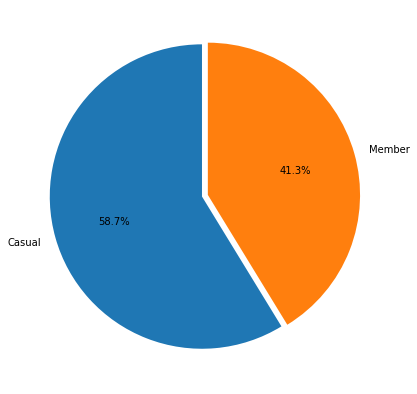

In [ ]:
# Percentage of users between subscribers and customers
fig, ax = plt.subplots(figsize = (7,7))
plt.pie(df_trip_post['member_casual'].value_counts(), labels = ['Casual', 'Member'], 
        startangle = 90, explode = (0, 0.04), autopct = '%1.1f%%')

plt.show()

## Bike types and usage per user type
-  Observation 
  -  In each user group, electric bikes are used more than other bike types
  -  Casual users tends to ride eletric bike in comparison to member user.
  -  There are less than 3000 docked bike ussage history which is negligible to other bike types. 






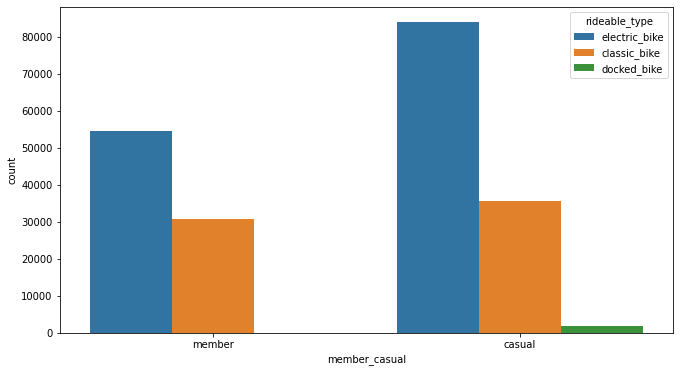

In [ ]:
# Percentage of users between subscribers and customers
fig, ax = plt.subplots(figsize = (11,6))
sns.countplot(data = df_trip_post, x = 'member_casual', hue = 'rideable_type')
plt.show()

## Bike users' Geographical analysis 
- Ride start and end location on the map can reveal the geographical bike ride trend and freqency(density)

- Reference: https://medium.com/@sindhu.ravikumar/visualizing-spatial-data-with-geopandas-and-contextily-10e9b8e71e49



In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import folium
import plotly_express as px
import contextily as ctx
import zipfile

! wget https://www2.census.gov/geo/tiger/TIGER2017//ROADS/tl_2017_06075_roads.zip
    
# Unzip shapefiles into shapefiles folder using unzip
with zipfile.ZipFile('tl_2017_06075_roads.zip', 'r') as zip_ref:
    zip_ref.extractall('shapefiles')

# Import shapefile as GeoDataFrame
geo_df = gpd.read_file('shapefiles/tl_2017_06075_roads.shp')

--2022-02-21 06:22:05--  https://www2.census.gov/geo/tiger/TIGER2017//ROADS/tl_2017_06075_roads.zip
Resolving www2.census.gov (www2.census.gov)... 104.124.136.170, 2600:1406:d000:28e::208c, 2600:1406:d000:2a2::208c
Connecting to www2.census.gov (www2.census.gov)|104.124.136.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘tl_2017_06075_roads.zip’

tl_2017_06075_roads     [ <=>                ] 586.77K  --.-KB/s    in 0.08s   

2022-02-21 06:22:05 (6.80 MB/s) - ‘tl_2017_06075_roads.zip’ saved [600849]



In [ ]:
geo_df.crs
geo_df = geo_df.to_crs(epsg=3857)

#### Initialize Bay area map

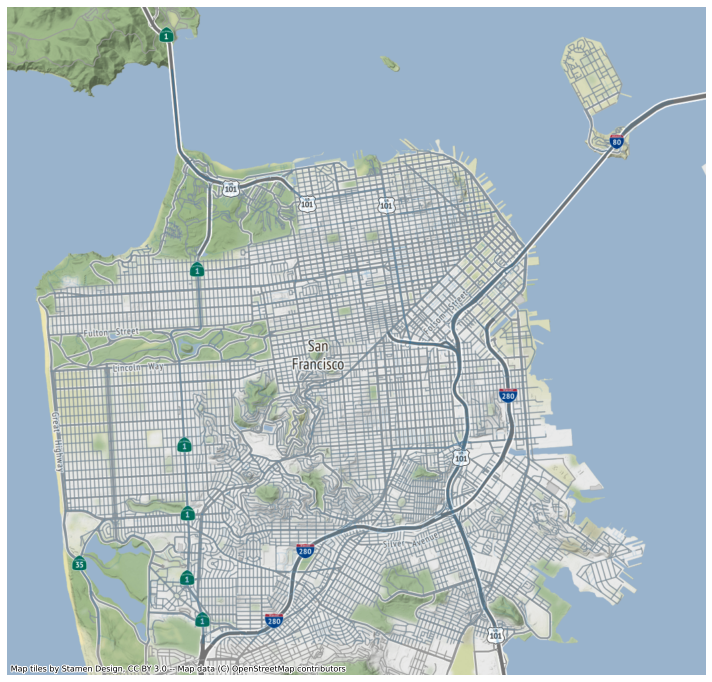

In [ ]:
# Initialize our plot
fig, ax = plt.subplots(figsize=(10,10))
# Plot our SF GeoDataFrame
geo_df.plot(ax=ax, alpha = .1)
# Add in a background using contextily
ctx.add_basemap(ax)
# Turn off axis
ax.set_axis_off()
fig.tight_layout()


### Start location 
- Start location distribution shows that bike rides are mostly concentrated on the most popular station in each area 
  - San Francisco : Market St at 10th st
  - San Jose : Sant James Park
  - Oakland : MacArcher Bart station

In [ ]:
# Add a geometry column that holds Point objects
df_trip_post['geometry'] = df_trip_post.apply(lambda x: Point(float(x.start_lng), float(x.start_lat)), axis=1)
# Convert Pandas DataFrame to a GeoDataFrame
station_geo_df = gpd.GeoDataFrame(df_trip_post, geometry='geometry')
# Initialize crs to 4326 because that's the format of our geomtry
station_geo_df.crs = "EPSG:4326"
# Change the crs to match our SF GeoDataFrame
station_geo_df = station_geo_df.to_crs(epsg = 3857)

Text(0.5, 1.0, 'Station Locations in San Francisco')

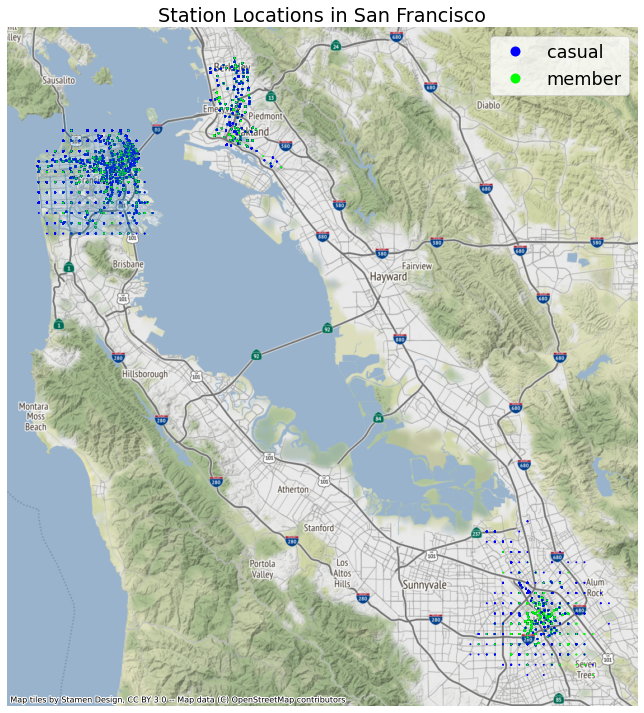

In [ ]:
# Change context for readability
sns.set_context("paper", font_scale=2)
# Initialize our plot
fig, ax = plt.subplots(figsize=(10,10))
# Plot our SF GeoDataFrame
geo_df.plot(ax=ax, alpha = .1)
# Plot our station locations
station_geo_df.plot(ax=ax, column = 'member_casual', cmap = 'brg', marker = '.', markersize=5, legend = True)
# Add in a background using contextily
ctx.add_basemap(ax)
# Turn off axis
ax.set_axis_off()
fig.tight_layout()
plt.title("Station Locations in San Francisco")

### End location
- End location distribution shows that bike rides are mostly concentrated on the most popular station in each area 
  - San Francisco : Market St at 10th st
  - San Jose : Alameda at Bush St
  - Oakland : MacArcher Bart station

In [ ]:
# Add a geometry column that holds Point objects
df_trip_post['geometry'] = df_trip_post.apply(lambda x: Point(float(x.end_lng), float(x.end_lat)), axis=1)
# Convert Pandas DataFrame to a GeoDataFrame
station_geo_df = gpd.GeoDataFrame(df_trip_post, geometry='geometry')
# Initialize crs to 4326 because that's the format of our geomtry
station_geo_df.crs = "EPSG:4326"
# Change the crs to match our SF GeoDataFrame
station_geo_df = station_geo_df.to_crs(epsg = 3857)

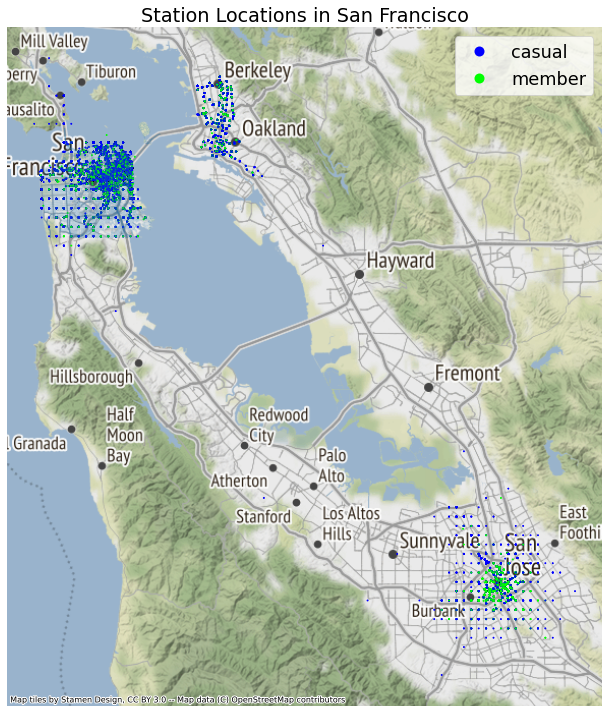

In [ ]:
# Change context for readability
sns.set_context("paper", font_scale=2)
# Initialize our plot
fig, ax = plt.subplots(figsize=(10,10))
# Plot our SF GeoDataFrame
geo_df.plot(ax=ax, alpha = .1)
# Plot our station locations
station_geo_df.plot(ax=ax, column = 'member_casual', cmap = 'brg', marker = '.', markersize=5, legend = True)
# Add in a background using contextily
ctx.add_basemap(ax)
# Turn off axis
ax.set_axis_off()
fig.tight_layout()
plt.title("Station Locations in San Francisco")
plt.savefig('Station_geospacial.png');

## Number of bike rides on weekdays/weekends for Member(registered) vs. Casual(unregistered)

- Observation : Casual and Member have very different ride behavior. It is possible that most registered member use bikes for commuting so bike rides count reduces during the weekends. Meanwhile, unregistered user's bike rides increases during the weekends. This means that many of the casual memebers use bike for non-commuting purpose such as sightseeing and hiking during the weekend. 

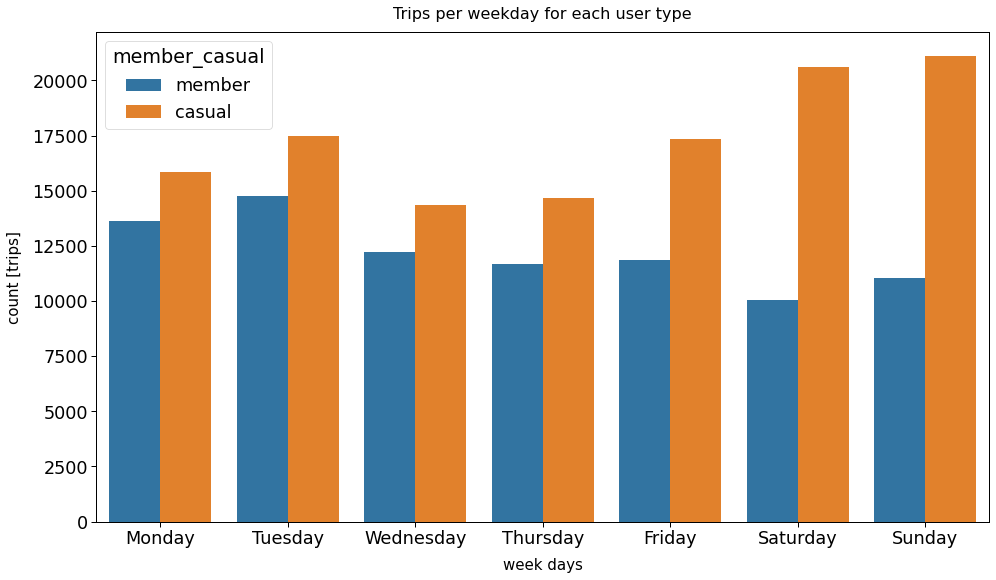

In [ ]:
# Bike rides per weekday for each user type
fig, ax = plt.subplots(figsize = (16,9))
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df_trip_post, x=df_trip_post['started_at'].dt.day_name(), hue='member_casual', order=weekdays)
plt.title('Trips per weekday for each user type', fontsize=16, y=1.015)
plt.xlabel('week days', labelpad=10, fontsize=15)
plt.ylabel('count [trips]', labelpad=10, fontsize=15)
plt.show();

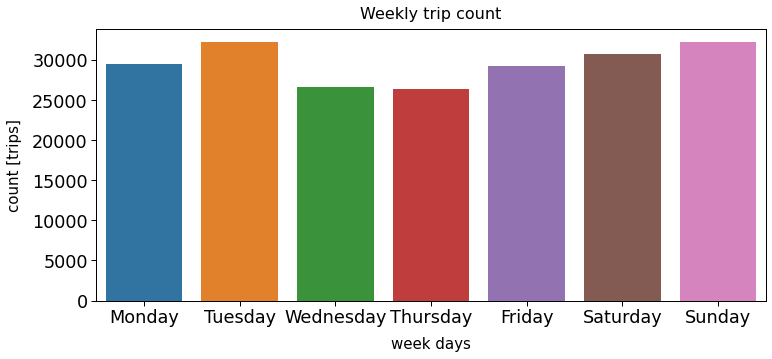

In [ ]:
# Bike rides per weekday for each user type
fig, ax = plt.subplots(figsize = (12,5))
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df_trip_post, x=df_trip_post['started_at'].dt.day_name(), order=weekdays)
plt.title('Weekly trip count', fontsize=16, y=1.015)
plt.xlabel('week days', labelpad=10, fontsize=15)
plt.ylabel('count [trips]', labelpad=10, fontsize=15)
plt.show();

## Create Important Metric : Daily Bike Occupancy index
- $B_o = \frac{N_{bike}(day)}{N_{average}} \cdot T_{average}(day) $

 where $N_{bike}(day)$,  $N_{average}$  ,and  $T_{average}(day)$ are "the number of total bike rides each day", "Average bike ride a day" and "average bike ride time duration". 

 - if $\frac{N_{bike}(day)}{N_{average}} < 1 $, daily rides of the bike on that day is below average and vice versa. So multiplying this with averaged daily travel time duration  $T_{average}(day)$ will give us bike occupancy of each day. This can be defined as new index called daily "Bike occupance index"

 - Bike occupancy index $B_o$ can be used to apply different pricing each day resulting in more balanced bike usage distribution. That will help maximize the bike utilization.



In [ ]:
# Convert time delta format of bike ride time duration into minutes
df_trip_post['day'] = df_trip_post['started_at'].dt.day_name()
df_trip_post['time_delta_int'] = pd.to_numeric(df_trip_post['time_delta'].dt.total_seconds()/60, downcast='integer')
df_trip_post['time_delta_int']

# Compute bike ride counts a day 
df_trip_post_stat = df_trip_post.groupby(['day'])['time_delta_int'].size().reset_index()
df_trip_post_stat.columns = ['day', 'bike_count_day']
# Compute and average bike time duration a day
df_trip_post_stat['mean_time_day'] = df_trip_post.groupby(['day'])['time_delta_int'].mean().reset_index()['time_delta_int']

# Compute bike occupance index
df_trip_post_stat['bike_occupancy_index'] = df_trip_post_stat['bike_count_day'] / df_trip_post_stat['bike_count_day'].mean() * df_trip_post_stat['mean_time_day']
df_trip_post_stat.sort_values(by="day")


,day,bike_count_day,mean_time_day,bike_occupancy_index
0,Friday,29200,16.525228,16.337633
1,Monday,29480,15.411531,15.382683
2,Saturday,30671,19.970954,20.738893
3,Sunday,32172,19.072766,20.775456
4,Thursday,26351,14.868820,13.265769
5,Tuesday,32273,14.648820,16.006664
6,Wednesday,26600,14.898452,13.417809


#### Bike occupance index 
- Finding 1: The result below shows that Bikes are gradually increases from Monday to Thursday. Then it drops to Friday suddenly. This is quite opposite to Bike ride count. It means that during the weekdays, many people doesn't return the bike and just occupies it. 

- Finding 2: During the weekend, even though more bikes are used during the weekend, bike occupance is not high. It means that many people use bike for relatively shorter time duration than one during the weekdays and return the bike. 
  - This implies that instead of purchasing more bikes to handle the weekend demand, it might be better to increase the bike re-allocation staffs for better bike circulation.

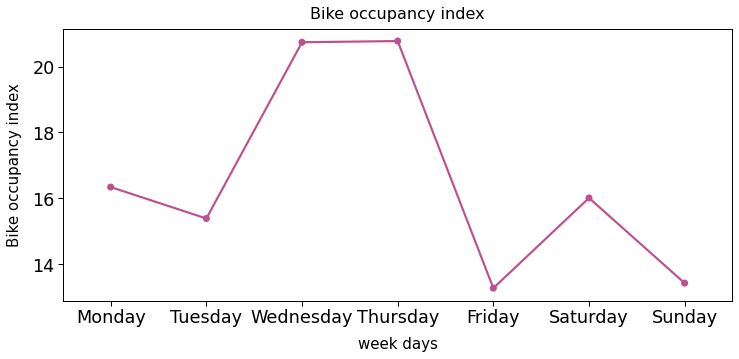

In [ ]:
# Bike rides per weekday for each user type
fig, ax = plt.subplots(figsize = (12,5))
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_trip_post_stat.set_index('day').loc[weekdays]['bike_occupancy_index']

sns.pointplot(x=df_trip_post_stat.set_index('day').loc[weekdays]['bike_occupancy_index'].index, y=df_trip_post_stat.bike_occupancy_index, color='#bc5090')
plt.title('Bike occupancy index', fontsize=16, y=1.015)
plt.xlabel('week days', labelpad=10, fontsize=15)
plt.ylabel('Bike occupancy index', labelpad=10, fontsize=15)
plt.show();


## Bike usage trend for 1 month
- 8/1, 8/8 ~~~ 8/29 are Saturday. Member's ride count goes down during the weekend. Meanwhile casual(unregistered) users count increases during the weekend. 


- This is aligned with initial observation that member mostly use bikes for commuting purpose so that bike ride reduces during the weekend while casual user bike rides increases during the weekend.

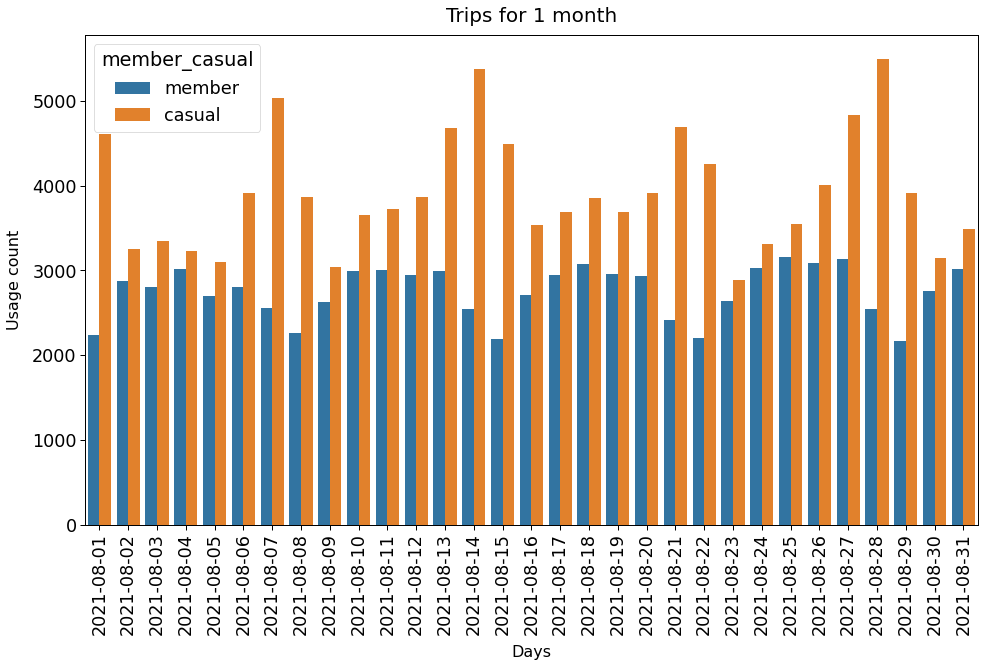

In [ ]:
fig, ax = plt.subplots(figsize = (16,9))

df_trip_post = df_trip_post.sort_values(by='started_at')

sns.countplot(data=df_trip_post.sort_values(by='started_at'), x=df_trip_post['started_at'].dt.to_period('D'), hue='member_casual');

plt.title('Trips for 1 month', fontsize=20, y=1.015)
plt.xlabel('Days', labelpad=10, fontsize=16)
plt.ylabel('Usage count', labelpad=10, fontsize=16)
# Use xticks to rotate the category labels (not axes) counter-clockwise
plt.xticks(rotation=90);

## Daily bike ride demand trend per bike type
- Since the previous bike type analysis showed that electric bikes are more popular than other types of bikes, it is worth investigating demand for the given time duration.

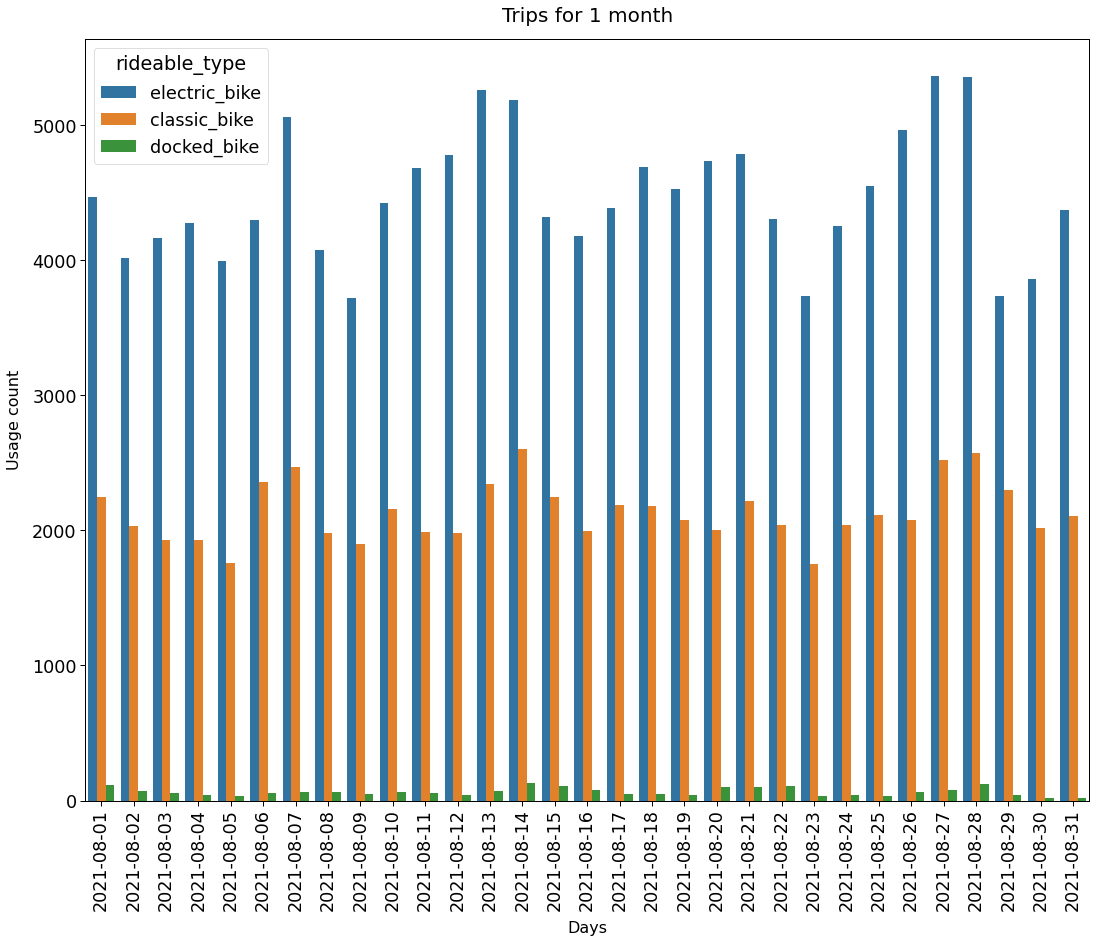

In [ ]:
fig, ax = plt.subplots(figsize = (18,14))

df_trip_post = df_trip_post.sort_values(by='started_at')

sns.countplot(data=df_trip_post.sort_values(by='started_at'), x=df_trip_post['started_at'].dt.to_period('D'), hue='rideable_type');

plt.title('Trips for 1 month', fontsize=20, y=1.015)
plt.xlabel('Days', labelpad=10, fontsize=16)
plt.ylabel('Usage count', labelpad=10, fontsize=16)
# Use xticks to rotate the category labels (not axes) counter-clockwise
plt.xticks(rotation=90);

### Bike ride fluctuation trend for 1 month per bike type
- The second order regressoin plot shows that electric bike ride increased can be visually confimred. On the otherhand, docked and electric bike usage didn't chage

- If there were more monthly ride data, more measnifuil bike ride statistics per bike type could be identified. 

  - This could be important statistics that can help purchase department plan the future bike pucahse plan with limited budget

         date     cols  vals
0  2021-08-01  classic  2250
1  2021-08-02  classic  2034
2  2021-08-03  classic  1932
3  2021-08-04  classic  1928
4  2021-08-05  classic  1762


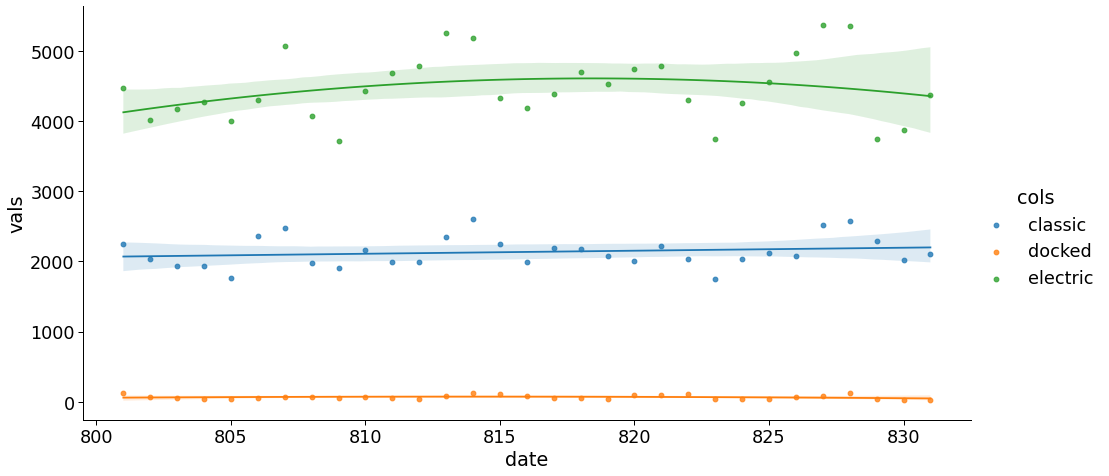

In [ ]:
import datetime
df_trip_post['date'] = df_trip_post['started_at'].dt.date
df_trip_post_bike_trend = df_trip_post.groupby(['date','rideable_type'])['date','rideable_type','started_at'].count()['started_at'].unstack()
df_trip_post_bike_trend = df_trip_post_bike_trend.reset_index()
df_trip_post_bike_trend.columns = ['date','classic','docked','electric']
df_trip_post_bike_trend_m = df_trip_post_bike_trend.melt('date', var_name='cols', value_name='vals')
print(df_trip_post_bike_trend_m.head(5))
date_for_zxis = df_trip_post_bike_trend_m['date']
df_trip_post_bike_trend_m['date'] = df_trip_post_bike_trend_m['date'].apply(lambda date: int(date.strftime("%m%d")))

ax = sns.lmplot(x="date", y="vals", hue="cols", data=df_trip_post_bike_trend_m ,order=2, height=7, aspect=2)


## Hourly trip data for each user type during a day
- Hourly data shows that member rides bike most at 5 pm and 8 am. 
- Hourly data shows that casual user tend to ride bikes more in the afternoon 
- Both user types rides bikes most at 5 pm when most people start to return home.

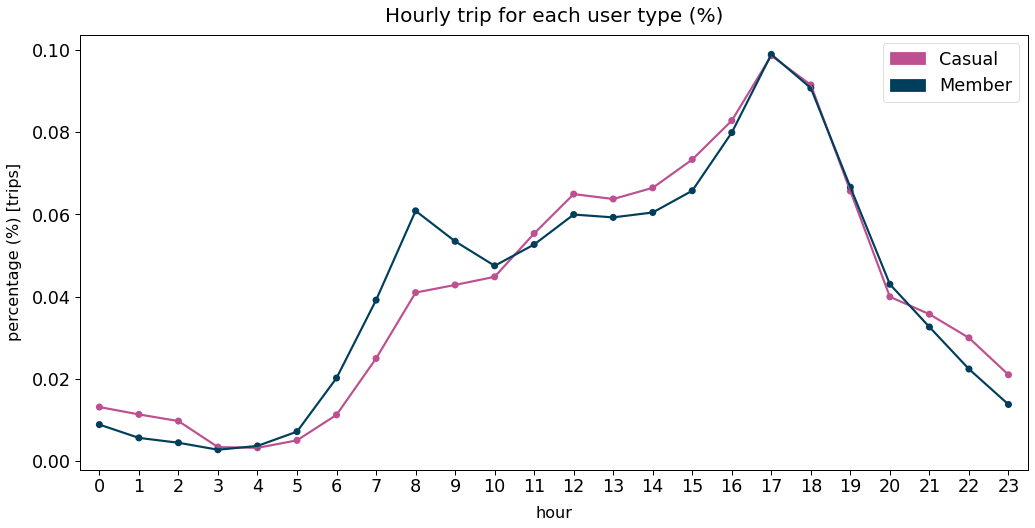

In [ ]:
# Creating masks for user type
customer = df_trip_post['member_casual'] == 'casual'
subscriber = df_trip_post['member_casual'] == 'member'

# Hours with most trips per user type
hourly_trips_customer = (df_trip_post.started_at[customer].dt.hour.value_counts().sort_index())/df_trip_post[customer].shape[0]
hourly_trips_subscriber = (df_trip_post.started_at[subscriber].dt.hour.value_counts().sort_index())/df_trip_post[subscriber].shape[0]

# Point plot for hourly rides per user type
rcParams['figure.figsize'] = 17,8
fig, ax = plt.subplots()
sns.pointplot(x=hourly_trips_customer.index, y=hourly_trips_customer.values, color='#bc5090')
sns.pointplot(x=hourly_trips_subscriber.index, y=hourly_trips_subscriber.values, color='#003f5c')
plt.title('Hourly trip for each user type (%)', fontsize=20, y=1.015)
plt.xlabel('hour', labelpad=10, fontsize=16)
plt.ylabel('percentage (%) [trips]', labelpad=10, fontsize=16)
# Creating artists specifically for adding to the legend (Proxy artists)
customer_legend = mpatches.Patch(color='#bc5090', label='Casual')
subscriber_legend = mpatches.Patch(color='#003f5c', label='Member')
plt.legend(handles=[customer_legend, subscriber_legend])
plt.show();

## Ride time duration related data analysis
- In order to check the ride time duration, the time duration in time delta format is converted to second format. Then histogram of the data was analyzed in the first histogram "ride time duration histogram" below. The result shows that due to some users that didn't return or occupied bike more than days, the histogram was right-skewed. In this analysis, we consider the extremely large time duration data as outlier and remove them from the analysis.
  - Data with ride time duration > 48 hours are removed as outlier

- After removing the outlier, the data shows clear trend. It's still right-skewed overall and around 500 minutes(8 hours) are the maximum ride frequency data point. This time matches the most common work hour 8.5 hours

Text(0.5, 1.0, 'Ride time duration histogram after removing outlier')

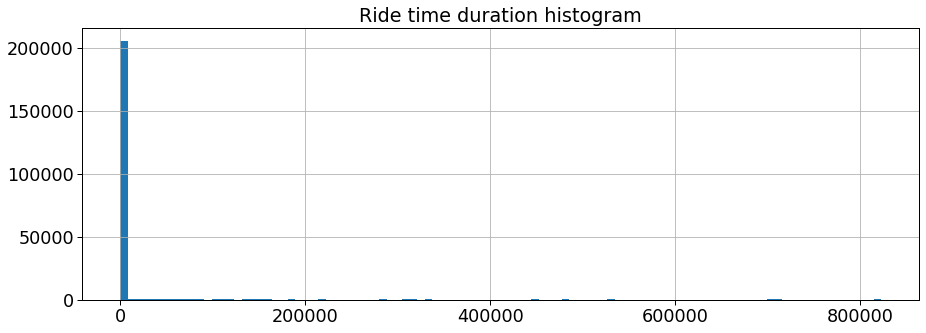

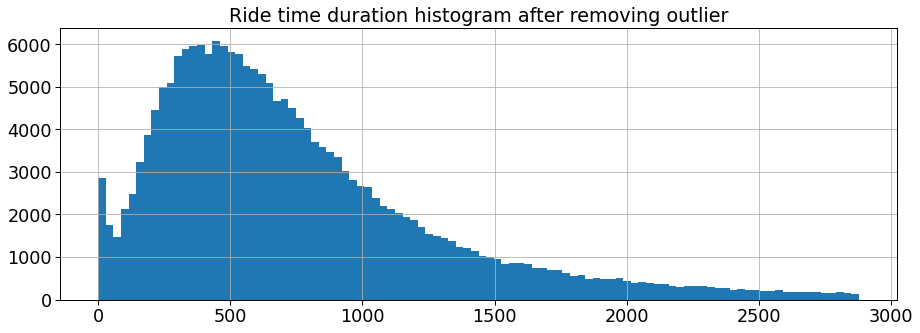

In [ ]:
# After quick time delta review, some users used bike for days and weeks. I considered that as outlier and removed from the data set.
df_trip_post2 = df_trip_post.copy(deep=True)
df_trip_post2['member_casual'] = df_trip_post2['member_casual']
df_trip_post2['time_duration_minute'] = (df_trip_post2['time_delta'].astype('timedelta64[s]')).abs()
fig = plt.subplots(figsize = (15,5))
df_trip_post2['time_duration_minute'].hist(bins=100)
plt.title('Ride time duration histogram')

# Removed data with more than 48 hours ride time
df_trip_post2 = df_trip_post2[ df_trip_post2['time_duration_minute']<1440 * 2 ] # Take only less than 48 hour data 48x60
fig = plt.subplots(figsize = (15,5))
df_trip_post2['time_duration_minute'].hist(bins=100)
plt.title('Ride time duration histogram after removing outlier')

### Violin plot of member type vs ride time duration
- Since ride time is important information, further analysis is made and ride time duration per user type data was visualized based on violin plot overlayed with box plot

- The result shows that casual users spend more time. The width of the violin plot revelas that the ride time duration of most of the members are 500 min (8.5 hours). Meanwhile casual, unregistered user's most frequent ride time is 3 hours longer than member's ride time. This consistentely aligned with our previous observation that member might use bike for commuting purpose while casual users use for other purpose such as sight seeting that needs early bike pick up and late return.

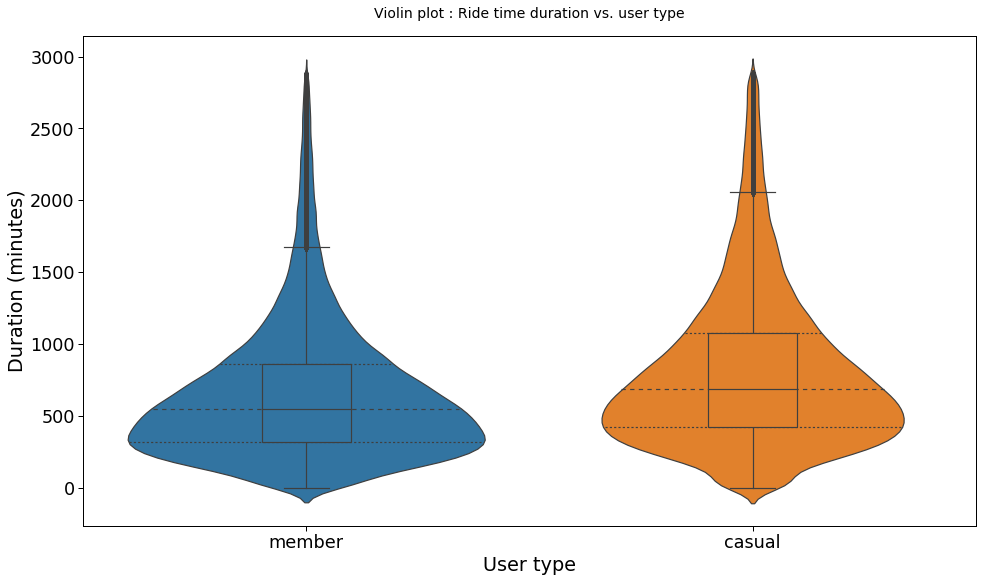

In [ ]:
# Violin plot of member type vs ride time duration
# Violin plot definition : https://towardsdatascience.com/violin-plots-explained-fb1d115e023d
fig = plt.subplots(figsize = (16,9))
ax = sns.violinplot(data=df_trip_post2, x='member_casual', y='time_duration_minute', inner='quartile')
sns.boxplot(data=df_trip_post2, x='member_casual', y='time_duration_minute', width=0.2, boxprops={'zorder': 2}, ax=ax)
plt.title('Violin plot : Ride time duration vs. user type', fontsize=14, y=1.025)
plt.xlabel('User type')
plt.ylabel('Duration (minutes)');

### Violin plot of ride time duration vs. weekday for each user type
- The analysis went one step further to see any difference between weekend and weekdays per member type.

- The violin plot below shows that there are no meaninful difference between weekend and weekdays

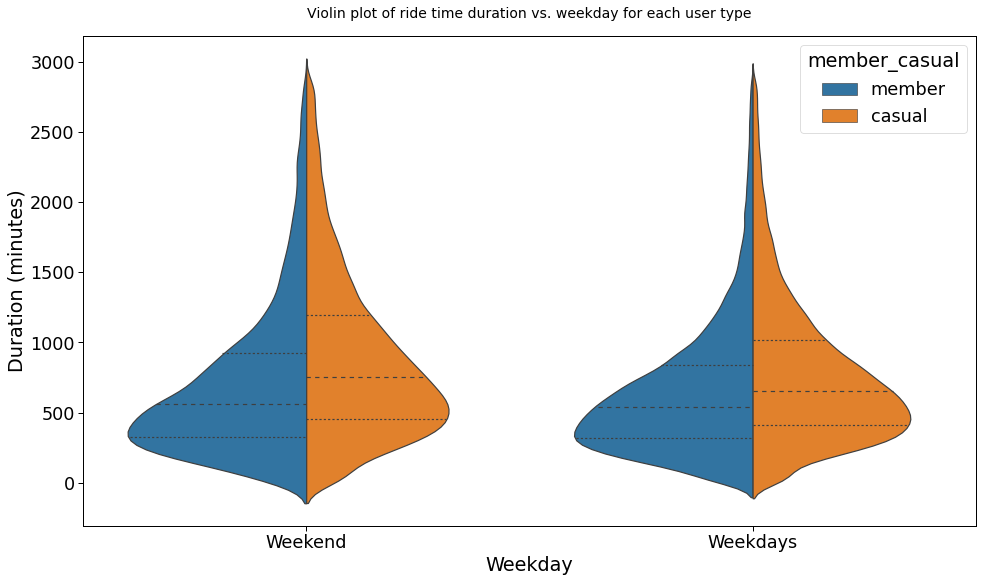

In [ ]:
# Violin plot of `is_weekend` vs `duration` for each user type
fig = plt.subplots(figsize = (16,9))
df_trip_post2['week_weekend'] = df_trip_post2['started_at'].dt.day_name().apply(lambda x: 'Weekend' if (x == 'Saturday' or x== 'Sunday') else 'Weekdays')
sns.violinplot(data=df_trip_post2, x=df_trip_post2['week_weekend'], y='time_duration_minute', hue='member_casual', inner='quartile', split=True)
plt.title('Violin plot of ride time duration vs. weekday for each user type', fontsize=14, y=1.025)
plt.xlabel('Weekday')
plt.ylabel('Duration (minutes)')
plt.show();

## Ride distance related data analysis

### Violin plot of member type vs ride distance
- Similary from the time duration, the ride distance was also analyzed. The result is simlar to the ride time duration violin plot.

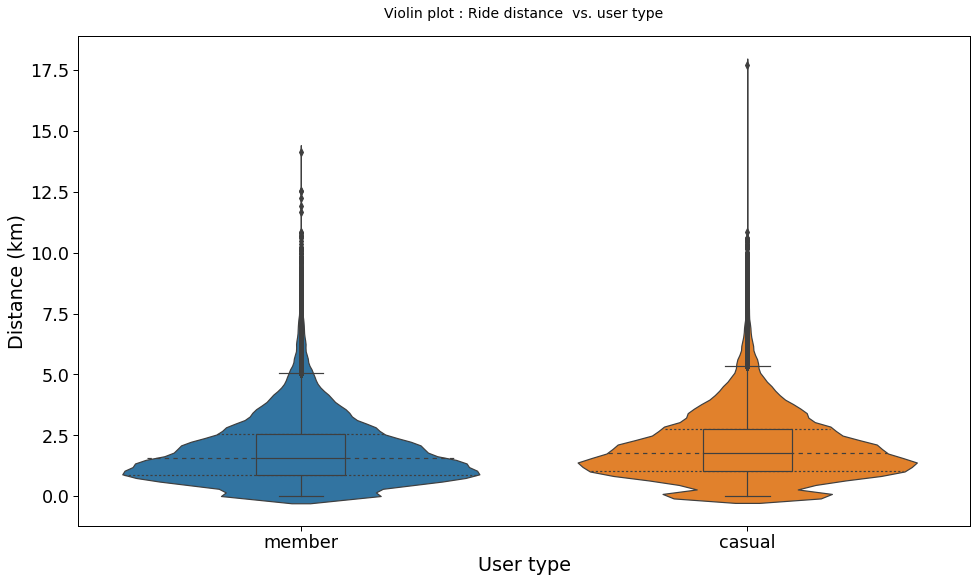

In [ ]:
# Violin plot of member type vs ride time duration
# Violin plot definition : https://towardsdatascience.com/violin-plots-explained-fb1d115e023d
fig = plt.subplots(figsize = (16,9))
ax = sns.violinplot(data=df_trip_post2, x='member_casual', y='dist_km', inner='quartile')
sns.boxplot(data=df_trip_post2, x='member_casual', y='dist_km', width=0.2, boxprops={'zorder': 2}, ax=ax)
plt.title('Violin plot : Ride distance  vs. user type', fontsize=14, y=1.025)
plt.xlabel('User type')
plt.ylabel('Distance (km)');

### Violin plot of ride distance(km) vs. weekday for each user type
- The distance pattern between weekend and weekdays are quite similar. 

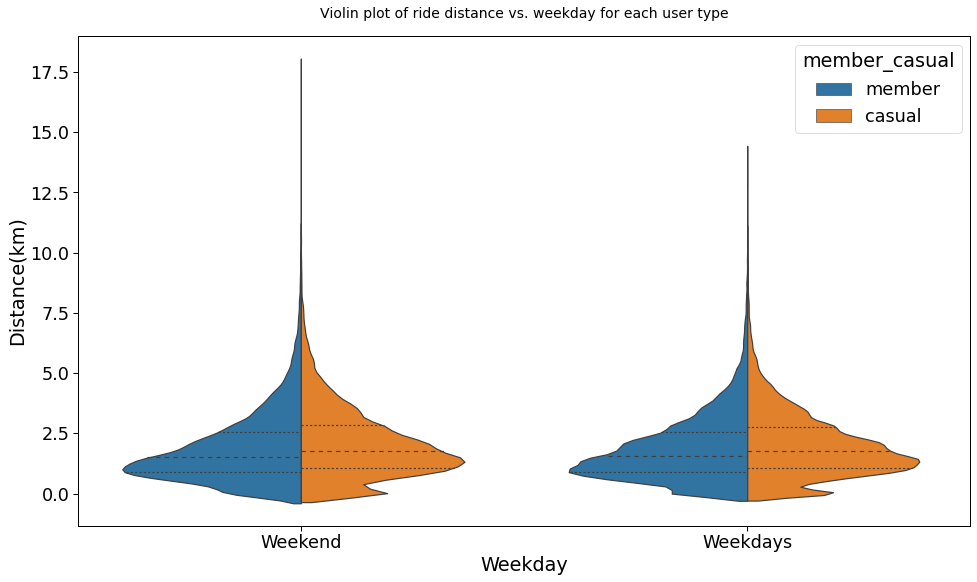

In [ ]:
# Violin plot of `is_weekend` vs `duration` for each user type
fig = plt.subplots(figsize = (16,9))
df_trip_post2['week_weekend'] = df_trip_post2['started_at'].dt.day_name().apply(lambda x: 'Weekend' if (x == 'Saturday' or x== 'Sunday') else 'Weekdays')
sns.violinplot(data=df_trip_post2, x=df_trip_post2['week_weekend'], y='dist_km', hue='member_casual', inner='quartile', split=True)
plt.title('Violin plot of ride distance vs. weekday for each user type', fontsize=14, y=1.025)
plt.xlabel('Weekday')
plt.ylabel('Distance(km)')
plt.show();